In [1]:
from parcels.interaction import HashNeighborSearch
from parcels.interaction import BruteNeighborSearch
from matplotlib import pyplot as plt

INFO: Compiled ParcelsRandom ==> /tmp/parcels-1000/libparcels_random_96ba5f3a-723d-4d7f-b062-83efe0060fd9.so


In [2]:
hash_bench = HashNeighborSearch.benchmark(10000)
brute_bench = BruteNeighborSearch.benchmark(10000)

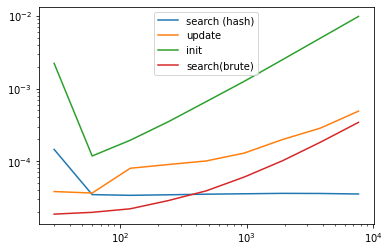

In [3]:
plt.plot(hash_bench['n_particles'], hash_bench["search_time"], label="search (hash)")
plt.plot(hash_bench['n_particles'], hash_bench["update_time"], label="update")
plt.plot(hash_bench['n_particles'], hash_bench["init_time"], label="init")
plt.plot(brute_bench['n_particles'], brute_bench['search_time'], label="search(brute)")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [4]:
24*8

192